In [1]:
#For a NVIDIA 2080Ti (11.G of VRAM), should also work with a 2080 (8.G of VRAM):
MAX_GPU_MATRIX_WIDTH = int(4096) #Max width of any matrix; scales quadraticaly with VRAM
MAX_GPU_NETWORK_DEPTH = int(6) #Max depth of any network; scales linearly with VRAM
#For same VRAM size, you can pick a different tradeoff between those two.
#You could also increase matrix width or network depth beyond these values if you reduce either your batch size or network width accordingly


In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import torch as torch

from sklearn.metrics import r2_score as r2
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import train_test_split as tts

from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.base import is_classifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score
from scipy.special import expit as logistic_func
from abc import ABCMeta, abstractmethod
import time

from sklearn.utils import check_random_state
from sklearn.utils import shuffle

#USE GPU
CUDA = True
if torch.cuda.is_available() and CUDA: dev = "cuda:0"
else: dev = "cpu"
device = torch.device(dev)

#quick shortcuts
def n2t(array):
    #numpy array to torch Tensor
    if type(array) == torch.Tensor: return array
    return torch.tensor(array).to(device).float()
def t2n(tensor):
    #torch Tensor to numpy array
    if type(tensor) == np.ndarray: return tensor
    return tensor.detach().to("cpu").numpy()
def n2f(array):
    #numpy array to float
    if type(array) == torch.Tensor: array = t2n(array)
    if type(array) == float: return array
    else: return np.array(array).reshape(-1)[0]
def f2s(value, length = 8, delimiter = " |"):
    #float to string with fixed length
    if type(value) == str:
        return " " * (length - len(value)) + value[:length] + delimiter
    else:
        return ("%." +str(length-6)+"e") % float(value) + delimiter

class BaseMLRNN(BaseEstimator, metaclass=ABCMeta):
    @abstractmethod
    def __init__(self, #see subclasses for default values
        depth,#number of hidden layers, int
        width, #number of neurons on hidden layers, int
        activation_function, #a torch function, str
        loss_function, #set by the subclass
                 
        optimizer, #a torch optimizer, str
        learning_rate, #float
        batch_size, #if None or False: full batch, if int number of samples, if float share of samples
        max_iter, #iterations, not epochs, int
        max_runtime, #unprecise, float or int
                 
        validation_fraction, #if None or False: no validation, if int number of samples, if float share of samples
        should_stratify, #validation split strategy, bool
        early_stopping_criterion, #either "loss" or "validation", str
        convergence_tol, #if None or False: always max_iter, else float 
        divergence_tol, #if None or False: always max_iter, else float 
        
        ridge_init, #if None or False: regular FFNN, if int or float lambda initial value, if "max_variation" or "min_value" grid-search
        n_permut, #if int number of permutations, if None or False no permutations
        label_noise_scale,#if float dithering white noise standard-deviation, if None or False no gaussian dithering
        target_rotation_scale,#if float dithering structured noise standard-deviation, if None or False no structured noise dithering
        
        random_state, #scikit-learn random state, will also set torch generator using a different seed
        verbose #if False mute, if True print at each iteration, if int print if iter%verbose == 0
                ):
        
        self.depth  = depth
        self.width  = width
        self.activation_function  = activation_function
        self.loss_function = loss_function
        self.optimizer  = optimizer
        self.learning_rate  = learning_rate
        self.batch_size  = batch_size
        self.max_iter  = max_iter
        self.max_runtime  = max_runtime
        self.validation_fraction  = validation_fraction
        self.should_stratify = should_stratify
        self.early_stopping_criterion  = early_stopping_criterion
        self.convergence_tol  = convergence_tol
        self.divergence_tol  = divergence_tol
        self.ridge_init  = ridge_init
        self.n_permut  = n_permut
        self.label_noise_scale  = label_noise_scale
        self.target_rotation_scale = target_rotation_scale
        self.random_state  = random_state
        self.verbose  = verbose
        
    def _init_valid(self, X, y):

        if self.validation_fraction in [False, None]:
            self.validation = False
            return X, None, y, None
        else:
            def roc_with_proba(y, probas): return roc_auc_score(y, probas[:,-1])
            self.valid_metric = roc_with_proba if is_classifier(self) else r2_score
            self.valid_func = self.predict_proba if is_classifier(self) else self.predict
            self.validation = True
            if self.should_stratify:
                if is_classifier(self): stratify = y 
                else: 
                    stratify = self._stratify_continuous_target(y)
            else: stratify = None
            X, X_valid, y, y_valid = train_test_split(
                X, y, random_state=self._random_state,
                test_size=self.validation_fraction,
                stratify=stratify)
            return X, n2t(X_valid), y, y_valid
        

    def _stratify_continuous_target(self, y):
        from sklearn.tree import DecisionTreeRegressor as tree_binarizer
        MAX_TRAINING_SAMPLES, MAX_TREE_SIZE = int(1e4), 50 #CPU memory and runtime safeguards
        tree_binarizer_params = {"criterion":'friedman_mse', 
                   "splitter":'best', 
                   "max_depth":None, 
                   "min_samples_split":2, 
                   "min_weight_fraction_leaf":0.0, 
                   "max_features":None,  
                   "min_impurity_decrease":0.2, 
                   "min_impurity_split":None, 
                   "ccp_alpha":0.0}
        
        tree_size = min(int(np.sqrt(len(y))), MAX_TREE_SIZE)
        fit_sample_size = min(len(y), MAX_TRAINING_SAMPLES)
        tree_binarizer_params["random_state"] = self._random_state
        tree_binarizer_params["max_leaf_nodes"] = tree_size
        tree_binarizer_params["min_samples_leaf"] = tree_size
        return tree_binarizer(**tree_binarizer_params).fit(y[:fit_sample_size].reshape((-1,1)), y[:fit_sample_size]).apply(y.reshape((-1,1)))
        
    def _valid_score(self, ):
        return self.valid_metric(self.y_valid, self.valid_func(self.X_valid))
    
    def _init_batch(self, n_samples):
        if type(self.batch_size) == float:
            self.batch_length = min(MAX_GPU_MATRIX_WIDTH, int(n_samples * self.batch_size))
            self.batch_learning = True
        elif type(self.batch_size) == int:
            self.batch_length = min(MAX_GPU_MATRIX_WIDTH, self.batch_size, n_samples)
            self.batch_learning = True
        elif n_samples > MAX_GPU_MATRIX_WIDTH:
            self.batch_length = int(MAX_GPU_MATRIX_WIDTH)
            self.batch_learning = True
        else:
            self.batch_learning = False
        if self.batch_learning:
            self.n_batches = int(n_samples / self.batch_length) 
            
    def _init_termination_criterion(self,):
        self.check_convergence = self.convergence_tol not in [False, None]
        self.check_divergence = self.divergence_tol not in [False, None]
        self.early_stopping = self.early_stopping_criterion not in [False, None]
        self.sign_criterion = -1. if self.early_stopping_criterion == "validation" else 1.
            
    def _init_MLR(self, ):
        self.ridge_output = self.ridge_init not in [False, None]
        self.add_MLR = self.ridge_output and self.n_permut not in [False, None, 0, 0.]   
        
    def _init_label_noise(self, ):
        self.add_label_noise = self.label_noise_scale not in [False, None, 0, 0.] 
        
    def _init_target_rotation(self, ):
        self.rotate_target = self.target_rotation_scale not in [False, None, 0, 0.] 
        
    def _init_hidden_weights(self, ):
        self.hidden_layers = []
        for layer in range(self.depth + 1 - int(self.ridge_output)):
            fan_in = self.n_features if layer == 0 else self.width
            fan_out = 1 if layer == self.depth else self.width
            factor = 2 if self.activation_function == "logistic" else 6 
            if self.activation_function == "relu": factor = factor * 2
            init_bound = np.sqrt(factor/(fan_in + fan_out))
            W = init_bound * (torch.rand((fan_in, fan_out), generator = self.torch_random_state, device = device)* 2. - 1.) 
            B = torch.zeros(size = (1,fan_out), device = device)
            self.hidden_layers.append([torch.nn.Parameter(weights) for weights in (W,B)])
            del W,B
        params = [weight for layer in self.hidden_layers for weight in layer]
        if self.ridge_output: self.hidden_layers.append([None, torch.zeros(size = (1,), device = device)])
        return params
    
    def _grid_search_ridge_coef(self, datas):
        GRID_START, GRID_END, GRID_SIZE = 1e-1, 1e4, 11
        candidates, losses = np.geomspace(GRID_START, GRID_END, GRID_SIZE),np.zeros(GRID_SIZE)
        with torch.no_grad():
            activation = self._forward_pass(datas["input"])
            target = self._add_noise(datas["target"])
            activation_dot_target = activation.transpose(1,0) @ self._scale_target(target)
            activation_dot_target_permuted = None
            if self.add_MLR: 
                target_permuted = self._add_noise(datas["target_permuted"])
                activation_dot_target_permuted = activation.transpose(1,0) @ self._scale_target(target_permuted)
            for i,candidate in enumerate(candidates):
                activation_dot_inv_mat = activation @ self._get_inv_mat(activation, n2t(np.log(candidate)), only_inversion = True)
                loss = self._compute_loss(activation_dot_inv_mat @ activation_dot_target, target)
                if self.add_MLR: loss += self._compute_MLR_penalty(activation_dot_inv_mat @ activation_dot_target_permuted, target_permuted)
                losses[i] = n2f(t2n(loss))
            
        if self.ridge_init == "max_variation":
            return np.geomspace(GRID_START, GRID_END, GRID_SIZE-1)[np.argmax(losses[1:] - losses[:-1])]
        else:
            return candidates[np.argmin(losses)]
    
    def _init_ridge_coef(self, datas):
        if self.ridge_output:

            if type(self.ridge_init) in [float, int] or isinstance(self.ridge_init, np.number):
                ridge_coef = self.ridge_init
                
            elif self.ridge_init in ["min_value", "max_variation"]:
                ridge_coef = self._grid_search_ridge_coef(datas)
            else:
                ridge_coef = 1.
                
            self.ridge_coef = torch.nn.Parameter(n2t(np.log(ridge_coef)))
            return [self.ridge_coef]     
        else:
            return []
        
    def _init_record(self, ):
        self.record = {}
        self.record["loss"] = []
        self.record["time"] = []
        if self.validation:
            self.record["validation"] = []
        if self.ridge_output:
            self.record["lambda"] = []
        if self.add_MLR:
            self.record["mlr"] = []
            
    def _init_intercept(self, target):
        if self.add_MLR:
            with torch.no_grad():
                pred = target.mean() * torch.ones(target.shape, device = device)
                self.intercept = self._compute_loss(self._scale_target(pred), target).detach()
            
    def _initialize(self, X, y):
        self.init_time = time.time()
        self._random_state = check_random_state(self.random_state)
        self.torch_random_state = torch.Generator(device=device).manual_seed(int(self._random_state.uniform(0,2**31)))
        self.print_record  = self.verbose not in [0, False]
        X, self.X_valid, y, self.y_valid = self._init_valid(X, y)
        n_samples, self.n_features = X.shape
        self._init_termination_criterion()
        self._init_batch(n_samples)
        self._init_MLR()
        self._init_record()
        self._init_label_noise(), self._init_target_rotation()
        self.act_func = getattr(torch, self.activation_function)
        self.loss_func = getattr(torch.nn,self.loss_function)(reduction='none')
        
        datas = self._init_data(X,y)
        self._init_intercept(datas["target"])
        params = self._init_hidden_weights()
        params = params + self._init_ridge_coef(datas)
        self.optimizer_instance  = getattr(torch.optim, self.optimizer)(lr = self.learning_rate, params = params)
        del params
        self.current_iter = 0
        self.init_time = time.time() - self.init_time
        return X, y, datas
    
    def _reduce_loss(self, point_wise_loss):
        if self.loss_function == "MSE":
            return torch.sqrt(point_wise_loss.mean(dim = 0))
        else: return point_wise_loss.mean(dim = 0)
        
        
    def _init_data(self, X,y):
        datas = {"X":X, "y":y}
        if self.add_MLR:
            datas["y_permuted"] = self._permut_label(y)
            
        if self.batch_learning:
            self._generate_batch(datas["X"].shape[0])
            datas = self._update_data(datas)
        else: 
            datas["input"] = n2t(datas["X"])
            datas["target"] = n2t(datas["y"])
            if self.add_MLR: datas["target_permuted"] = n2t(datas["y_permuted"])
        return datas
            
        
    def _generate_batch(self, n_samples):
        shuffled_indexes = shuffle(np.arange(n_samples),random_state=self._random_state)
        self.batches = [shuffled_indexes[batch_i * self.batch_length: (batch_i + 1) * self.batch_length] for batch_i in range(self.n_batches)]
        
    def _update_data(self, datas):
        if self.batch_learning:
            if len(self.batches) == 0:
                self._generate_batch(datas["X"].shape[0])
            batch_indexes = self.batches.pop(0)
            datas["input"] = n2t(datas["X"][batch_indexes])
            datas["target"] = n2t(datas["y"][batch_indexes])
            if self.add_MLR: datas["target_permuted"] = n2t(datas["y_permuted"][batch_indexes])
        return datas
    
    def _permut_label(self, y):
        y_index = np.arange(len(y))
        return np.concatenate([y[shuffle(y_index,random_state=self._random_state)].reshape((-1,1)) for permut in range(self.n_permut)], axis=1)
        
    def _forward_propagate(self, datas):
        activation = datas["input"]
        target = self._add_noise(datas["target"])
        activation = self._forward_pass(activation)
        
        if self.ridge_output:
            inv_mat = self._get_inv_mat(activation, self.ridge_coef)
            beta = inv_mat @ self._scale_target(target)
            self.hidden_layers[-1][0] = beta
            pred = activation @ beta
            if self.rotate_target:
                projection = activation @ inv_mat
                pred, target = self._rotate_pred(projection, pred, target)
        else:
            pred = activation.reshape(-1)
        loss = self._compute_loss(pred, target)
        self.record["loss"].append(n2f(t2n(loss)))
        if self.add_MLR:
            target_permutation = self._add_noise(datas["target_permuted"])
            if not self.rotate_target: projection = activation @ inv_mat
            pred_permutation = projection @ self._scale_target(target_permutation)
            if self.rotate_target:
                pred_permutation, target_permutation = self._rotate_pred(projection, pred_permutation, target_permutation)
            permut_loss = self._compute_MLR_penalty(pred_permutation, target_permutation)
            self.record["mlr"].append(n2f(t2n(permut_loss)))
            loss += permut_loss
        if self.validation: self.record["validation"].append(self._valid_score())
        if self.early_stopping: self._save_weights()
        if self.ridge_output:
            self.record["lambda"].append(np.exp(n2f(t2n(self.ridge_coef))))
        self.record["time"].append(time.time() - self.current_time)
        self.current_time = time.time()
        if self.print_record: 
            if self.current_iter == 0:
                print("| "+f2s("iter"), *map(f2s, self.record.keys()))
            if self.current_iter % int(self.verbose) == 0:
                print("| "+f2s(str(self.current_iter)), *map(lambda value : f2s(value[-1]), self.record.values()))
                      
        return loss
        
    def _add_noise(self, target):
        if self.add_label_noise:
            return target  + torch.normal(0., self.label_noise_scale, size = target.shape, generator = self.torch_random_state, device = device)
        else:
            return target
        
    def _rotate_pred(self, projection, prediction, target):
        if self.rotate_target:
            epsilon = torch.normal(0.,self.target_rotation_scale, size = target.shape ,generator = self.torch_random_state, device = device)
            complementary = epsilon - projection @ epsilon
            return (prediction + target)/2 + complementary, target
        else:
            return prediction, target
        
    def _scale_target(self, target):
        if is_classifier(self):
            return target * 2. - 1.
        else:
            return target
        
    def _forward_pass(self, activation):
        for layer,(W,B) in enumerate(self.hidden_layers[:self.depth + 1 - int(self.ridge_output)]):
            activation = activation @ W + B
            if layer < self.depth: activation = self.act_func(activation)
        return activation
    
    def _get_inv_mat(self, activation, ridge_coef, only_inversion = False):
        diag = torch.diag(torch.ones(activation.shape[1],device = device) * torch.exp(ridge_coef))
        inversed = torch.inverse((activation.transpose(1,0) @ activation) + diag)
        if only_inversion: return inversed
        else: return inversed @ activation.transpose(1,0)
      
    def _compute_loss(self, pred, target):
        return self._reduce_loss(self.loss_func(pred, target)).mean()
        
    def _compute_MLR_penalty(self, pred, target):
        return torch.abs(self.intercept - self._reduce_loss(self.loss_func(pred, target))).mean()
        
    def _backward_propagate(self, loss):
        loss.backward()
        self.optimizer_instance.step()
        self.optimizer_instance.zero_grad()
        self.current_iter = self.current_iter + 1
        
    def _check_termination(self,):
        return self._check_convergence() or self._check_divergence() or self._check_timeout() or self.current_iter >= self.max_iter
    def _check_convergence(self, ):
        if self.check_convergence:
            return np.abs(np.min(self.record["loss"][:-1]) - self.record["loss"][-1]) < self.convergence_tol
        else: return False
    def _check_divergence(self, ): 
        if self.check_divergence:
            return self.record["loss"][-1] > self.divergence_tol
        else: return False
    def _check_timeout(self, ):
        return self.max_runtime < self.init_time + np.sum(self.record["time"])
    def _save_weights(self,):
        if self.current_iter == 0:
            self.best_iter = self.current_iter
        elif self.record[self.early_stopping_criterion][-1] * self.sign_criterion < self.record[self.early_stopping_criterion][self.best_iter] * self.sign_criterion:
            self.best_iter = self.current_iter
            del self.saved_hidden_layers
        if self.current_iter == self.best_iter:
            saved_weights_device = device if self.depth <= MAX_GPU_NETWORK_DEPTH/2 else torch.device("cpu")
            self.saved_hidden_layers = [[torch.clone(weights).detach().to(saved_weights_device) for weights in couple] for couple in self.hidden_layers]
    def _load_weights(self,):
        self.hidden_layers = [[weights.to(device) for weights in couple] for couple in self.saved_hidden_layers]
        del self.saved_hidden_layers
        
    def _release_train_memory(self):
        if self.validation: del self.X_valid, self.y_valid
        if self.ridge_output: del self.ridge_coef
        del self.optimizer_instance
        torch.cuda.empty_cache()
        

    def _forward_pass_fast(self, activation):
        with torch.no_grad():
            for layer,(W,B) in enumerate(self.hidden_layers):
                activation = activation @ W + B
                if layer < self.depth: activation = self.act_func(activation)
            del W,B
        return activation
    
    def _predict_hidden(self, X):
        if X.shape[0] <= MAX_GPU_MATRIX_WIDTH:
            return t2n(self._forward_pass_fast(n2t(X)))
        else:
            return np.concatenate([ self._predict_hidden(X[:MAX_GPU_MATRIX_WIDTH]), self._predict_hidden(X[MAX_GPU_MATRIX_WIDTH:])])
 
    
    def _fit(self, X, y, incremental=False):
        if incremental:
            datas = self._init_data(X,y)
        else:
            X, y, datas = self._initialize(X, y)
            
        self.current_time = time.time()
        loss = self._forward_propagate(datas)
        while not self._check_termination():
            self._backward_propagate(loss)
            del loss
            datas = self._update_data(datas)
            loss = self._forward_propagate(datas)
            
        del loss
        if self.early_stopping: self._load_weights()
        self._release_train_memory()  
        return self
        
    def fit(self, X, y):
        return self._fit(X,y, incremental=False)
    
    def delete_model_weights(self):
        del self.hidden_layers
        torch.cuda.empty_cache()
    
    def partial_fit(self, X, y):
        #does not work currently
        return self._fit(X,y, incremental=True)
    
       
class MLRNNClassifier(ClassifierMixin, BaseMLRNN):
    def __init__(self, *,
        depth = 1,
        width = 4096,
        activation_function = "relu",
        optimizer = "Adam",
        learning_rate = 1e-2,
        batch_size = False,
        max_iter = 50,
        max_runtime = 300,       
        validation_fraction = 0.2,
        should_stratify = True,
        early_stopping_criterion = "validation",
        convergence_tol = False,
        divergence_tol = False,
        ridge_init = "max_variation",
        n_permut = 16,
        label_noise_scale = None,
        target_rotation_scale = 1.,
        random_state = None,
        verbose = False
                ):
        super().__init__(
        depth  = depth, width  = width, activation_function  = activation_function,
        loss_function = 'BCEWithLogitsLoss', optimizer  = optimizer, learning_rate  = learning_rate,
        batch_size  = batch_size, max_iter  = max_iter, max_runtime  = max_runtime, validation_fraction  = validation_fraction,
        should_stratify= should_stratify, early_stopping_criterion  = early_stopping_criterion, convergence_tol  = convergence_tol, divergence_tol  = divergence_tol,
        ridge_init  = ridge_init, n_permut  = n_permut, label_noise_scale  = label_noise_scale,
        target_rotation_scale =  target_rotation_scale, random_state  = random_state, verbose  = verbose)
    
    def predict(self, X):
        return self._predict_hidden(X) >= 0.
        
    def decision_function(self, X):
        return self._predict_hidden(X)
    
    def predict_proba(self, X):
        proba = logistic_func(self._predict_hidden(X))
        return np.c_[1.-proba, proba]
    
class MLRNNRegressor(RegressorMixin, BaseMLRNN):
    def __init__(self, *,
        depth = 1,
        width = 4096,
        activation_function = "relu",  
        optimizer = "Adam",
        learning_rate = 1e-2,
        batch_size = False,
        max_iter = 50,
        max_runtime = 300,       
        validation_fraction = 0.2,
        should_stratify = True,
        early_stopping_criterion = "validation",
        convergence_tol = False,
        divergence_tol = 1.,
        ridge_init = "max_variation",
        n_permut = 16,
        label_noise_scale = 0.03,
        target_rotation_scale = 0.5,
        random_state = None,
        verbose = False
                ):
        super().__init__(
        depth  = depth, width  = width, activation_function  = activation_function,
        loss_function = 'MSELoss', optimizer  = optimizer, learning_rate  = learning_rate,
        batch_size  = batch_size, max_iter  = max_iter, max_runtime  = max_runtime, validation_fraction  = validation_fraction,
        should_stratify = should_stratify, early_stopping_criterion  = early_stopping_criterion, convergence_tol  = convergence_tol, divergence_tol  = divergence_tol,
        ridge_init  = ridge_init, n_permut  = n_permut, label_noise_scale  = label_noise_scale,
        target_rotation_scale =  target_rotation_scale, random_state  = random_state, verbose  = verbose)
    
    def predict(self, X):
        return self._predict_hidden(X)

# Load ablation datasets

In [3]:
from sklearn.preprocessing import StandardScaler as normalize
def dataset_loader(dataset_id, name, repository):
    return np.load(repository + name + str(dataset_id) + ".npy")
def prepare_dataset(dataset, train_size = 0.8, seed= False):
    kwargs = {}
    if seed or type(seed) == type(0):
        kwargs["random_state"] = seed
    X, y = dataset[:, :-1], dataset[:, -1]
    X = normalize().fit_transform(X)
    X_train, X_test, y_train, y_test = tts(X, y, train_size = train_size, **kwargs)
    return X_train, X_test, y_train, y_test
def get_dataset(dataset_id, name, repository, train_size = 0.8, seed = False):
    return prepare_dataset(dataset_loader(dataset_id, name, repository), train_size = train_size, seed = seed)

In [4]:
#set architectures hyper-parameters
from copy import deepcopy
common_parameters = {"max_runtime" : 900, "width":1024}
common_parameters["label_noise_scale"] = False #no gaussian dithering
common_parameters["validation_fraction"] = 0.5 #get a better estimation of generalization performance

MLR2_parameters = deepcopy(common_parameters)
MLR2_parameters["depth"] = 2
MLR2_parameters["learning_rate"] = 1e-3
MLR2_parameters["max_iter"] = 200

NN2_Ridge_Permut_parameters = deepcopy(MLR2_parameters)
NN2_Ridge_Permut_parameters["ridge_init"] = "max_variation"
NN2_Ridge_Permut_parameters["n_permut"] = 16
NN2_Ridge_Permut_parameters["target_rotation_scale"] = False

NN2_Ridge_SD_parameters = deepcopy(MLR2_parameters)
NN2_Ridge_SD_parameters["ridge_init"] = "max_variation"
NN2_Ridge_SD_parameters["n_permut"] = False
NN2_Ridge_SD_parameters["target_rotation_scale"] = 0.5

NN2_Ridge_parameters = deepcopy(MLR2_parameters)
NN2_Ridge_parameters["ridge_init"] = "max_variation"
NN2_Ridge_parameters["n_permut"] = False
NN2_Ridge_parameters["target_rotation_scale"] = False

NN2_parameters = deepcopy(MLR2_parameters)
NN2_parameters["ridge_init"] = False
NN2_parameters["n_permut"] = False
NN2_parameters["target_rotation_scale"] = False
NN2_parameters["divergence_tol"] = False #overwise worst results

permut_compared_architectures = ["MLR2", "NN2_Ridge_Permut"]
ridge_compared_architectures = ["MLR2", "NN2_Ridge_Permut", "NN2_Ridge_SD", "NN2_Ridge"]
all_similar_architectures = ["MLR2", "NN2_Ridge_Permut", "NN2_Ridge_SD", "NN2_Ridge", "NN2"]

# Get records

In [5]:
input_name = "regression" 
input_repository = "../preprocessed_datasets/"
train_size = 0.99 #we will use the validation subset for generalization instead of test set
seed = 0
rs = 0
verbose = False
datasets = [0] # Concrete slump, smallest ds from the ablation study
dataset_id = datasets[-1]
def numpyfy(dic):
    for key,value in dic.items():
        dic[key] = np.array(value)
    return dic

In [6]:
records = {}
for dataset_id in datasets:
    records[dataset_id] = {}
    X_train, X_test, y_train, y_test = get_dataset(dataset_id, input_name, input_repository, train_size = train_size, seed = seed)
    for architecture in all_compared_architectures:
        reg = MLRNNRegressor(random_state=rs, verbose = verbose, **eval(architecture+"_parameters"))
        reg.fit(X_train,y_train)
        records[dataset_id][architecture] = numpyfy(reg.record)
        reg.delete_model_weights() 
        del reg

# Plot

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
plt.rcParams["figure.figsize"] = (15,8)

In [9]:
identity = lambda x : x
cliped = lambda x : np.clip(x,0,1)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
from functools import partial
ma = lambda x : partial(moving_average, w = 10)(x)
plot_func = cliped # identity, clipped, ma...

# Training loss

Text(0.5, 1.0, 'Train RMSE accross iterations')

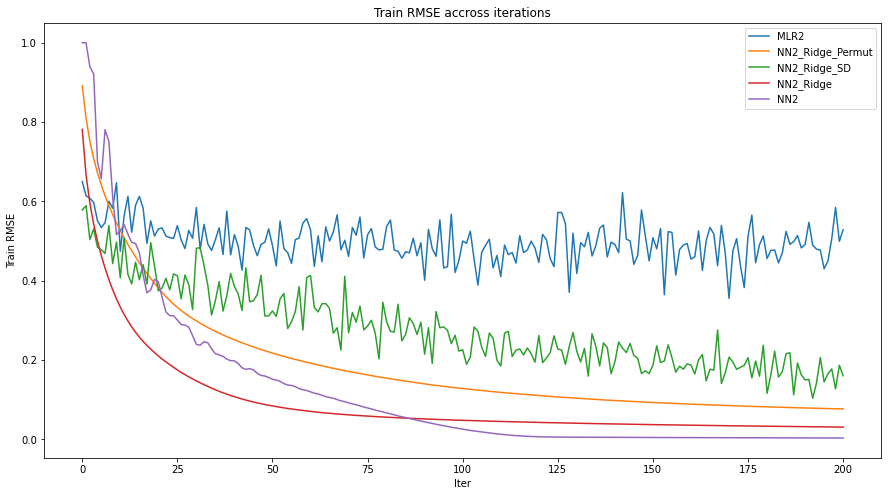

In [10]:
for architecture in all_similar_architectures:
    plt.plot(plot_func(np.sqrt(records[dataset_id][architecture]["loss"])), label = architecture)
plt.legend()
plt.xlabel("Iter")
plt.ylabel("Train RMSE")
plt.title("Train RMSE accross iterations")

Observations : 
- Without Structured Dithering and Permutations, the model fully memorizes the train set.
- Structured Dithering adds oscillations to the training loss.

Text(0.5, 1.0, 'Permut MSE accross iterations')

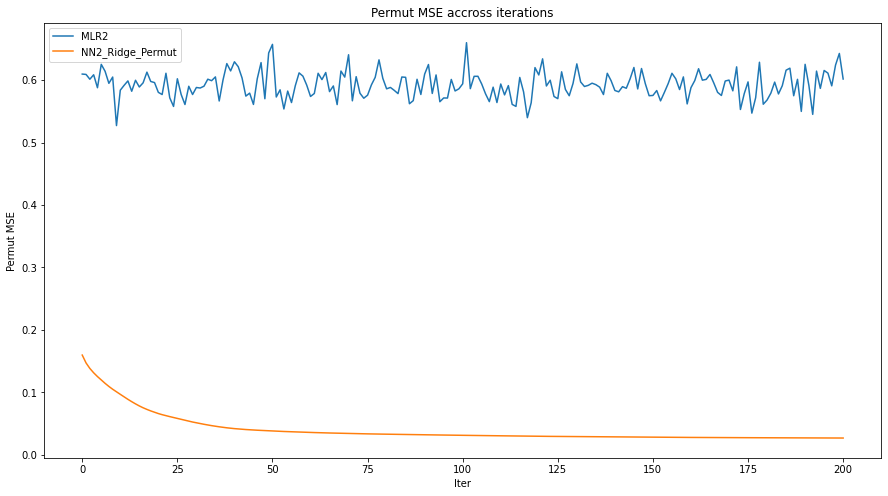

In [11]:
for architecture in permut_compared_architectures:
    plt.plot(plot_func(records[dataset_id][architecture]["mlr"]), label = architecture)
plt.legend()
plt.xlabel("Iter")
plt.ylabel("Permut MSE")
plt.title("Permut MSE accross iterations")

Observations : 
- Without Structured Dithering it is still possible to minimize both sides of the MLR loss expression.
- The MLR loss actually performs a good trade off between these two antagonist objectives.

# Generalization Performance

Text(0.5, 1.0, 'Generalization performance')

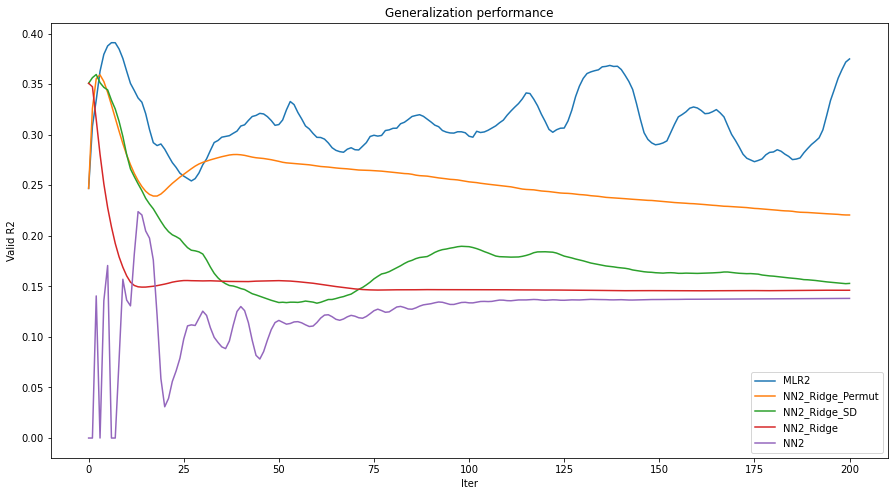

In [12]:
for architecture in all_similar_architectures:
    plt.plot(plot_func(records[dataset_id][architecture]["validation"]), label = architecture)
plt.legend()
plt.xlabel("Iter")
plt.ylabel("Valid R2")
plt.title("Generalization performance")
#MLR has weird variations

Observations : 
- Best performances are obtained after just a few iterations.
- MLR somewhat maintains these performances but with strange oscillations.
- Others fall back towards the standard FFNN performances.

Text(0.5, 1.0, 'Memorization')

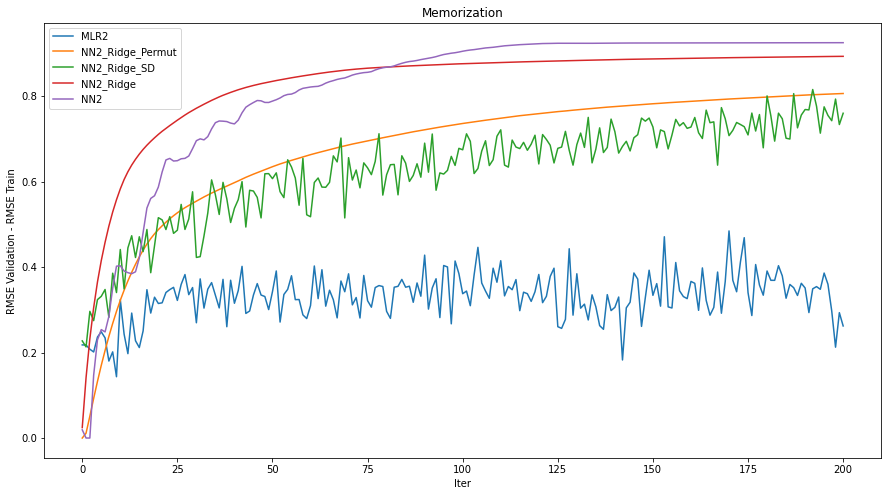

In [13]:
for architecture in all_similar_architectures:
    plt.plot(plot_func(np.sqrt(1 - records[dataset_id][architecture]["validation"])-np.sqrt(records[dataset_id][architecture]["loss"])), label = architecture)
plt.legend()
plt.xlabel("Iter")
plt.ylabel("RMSE Validation - RMSE Train")
plt.title("Memorization")


Observations : 
- MLR test and train performances have variations that seems to cancel each other out.
- MLR still memorizes but to a far lesser degree than the others.